# Food Inspections in Chicago: EDA and Modeling
https://www.kaggle.com/hamditarek/food-inspections-in-chicago-eda-and-modeling

- 참고할 코드(Fun in Text Mining with Chicago Food Inspections) : https://www.kaggle.com/ambarish/extensive-modelling-chicagofoodinspections/comments

시카고 식약청의 담당 공무원 ID(Inspection ID), 영업자 명(DBA Name, AKA Name), 영업자 신고번호(License #), 영업형태(Facility Type), 위험도(Risk), 주소, 점검 일
자(Inspection Date), 점검형태(Inspection Type), 점검결과(Results), 위반유형(Violations) 등의 변수를 확인할 수 있다. 우리가 주변에서 볼 수 있는 ‘Subway’와 ‘DUNKIN DONUT’S
가 각각 전체 점검비율의 1%로 상위를 차지하고 있다. 위도와 경도 위치 정보도 있어 지도로 시각화하여 살펴보기에 적합하다. 데이터의 형태도 수치형과 범주형 데이터가 혼재하고 있다.

-  In processing and analyzing the data, Chicago found several key predicting variables that, when observed, indicated there could be a considerable likelihood that a restaurant may earn a critical violation.  These predicting variables include the following:

      * Prior history of critical violations
      * Possession of a tobacco and/or incidental alcohol consumption license 
      * Length of time establishment has been operating
      * Length of time since last inspection
      * Location of establishment
      * Nearby garbage and sanitation complaints
      * Nearby burglaries
      * Three day average high temperature

-  These predictors were then factored together into a model, which was tested against food inspection procedures via a double-blind post-diction analysis.  In other words, after collecting a set of data, Chicago performed a simulation that used this past data to predict what its future outcome would have been under data-optimized conditions. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Imports
import pandas as pd
import numpy as np
import datetime
from folium import folium

import os
import gc           # Gabage Collection: 객체들을 순회하며 해당 객체가 현재 쓰이는곳이 없을 경우 자동으로 해제
gc.enable()
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

# Get Data

In [133]:
# Data import
#df = pd.read_csv("../data/food-inspections.csv")
#df.to_pickle('../data/food-inspections.pkl')
df = pd.read_pickle('../data/food-inspections.pkl')
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2352683,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,CHICAGO,IL,60613.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,Risk 1 (High),2900 W 63RD ST,CHICAGO,IL,60629.0,...,Not Ready,NaN,41.779190,-87.695892,"{'latitude': '-87.69589237398256', 'longitude'...",NaN,NaN,NaN,NaN,NaN


# Data preprocessing & EDA
### 1. Rename column name

In [134]:
df.rename(columns={"License #": "license"}, inplace=True)

### 2. Focus is only on “Canvass” inspections with successful inspections, Pass or Fail

In [135]:
df['Inspection Type'].value_counts(normalize=True).nlargest(5)

Canvass                  0.528365
License                  0.132372
Canvass Re-Inspection    0.105282
Complaint                0.092585
License Re-Inspection    0.045818
Name: Inspection Type, dtype: float64

In [136]:
df = df[df['Inspection Type'].notnull()]
df = df[df['Inspection Type']=='Canvass']

In [137]:
df.Results.value_counts()

Pass                    48877
Fail                    17781
Out of Business         16639
Pass w/ Conditions      15926
No Entry                 4683
Not Ready                  54
Business Not Located       35
Name: Results, dtype: int64

In [138]:
df = df[df.Results.isin(['Pass', 'Fail'])]

<AxesSubplot:>

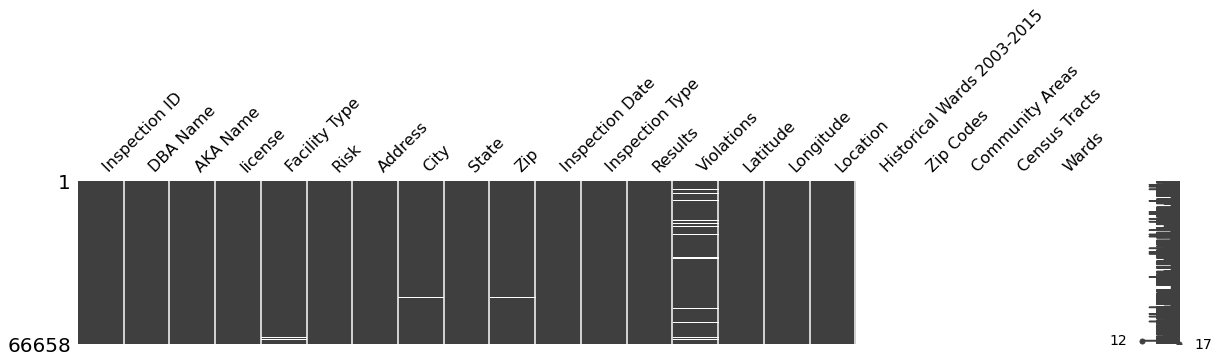

In [139]:
import missingno as msn
msn.matrix(df, figsize=(20,3))

### 3. Drop columns with missing data (>= 60% missing)

<AxesSubplot:>

Text(0.5, 1.0, 'The percentage of missing values')

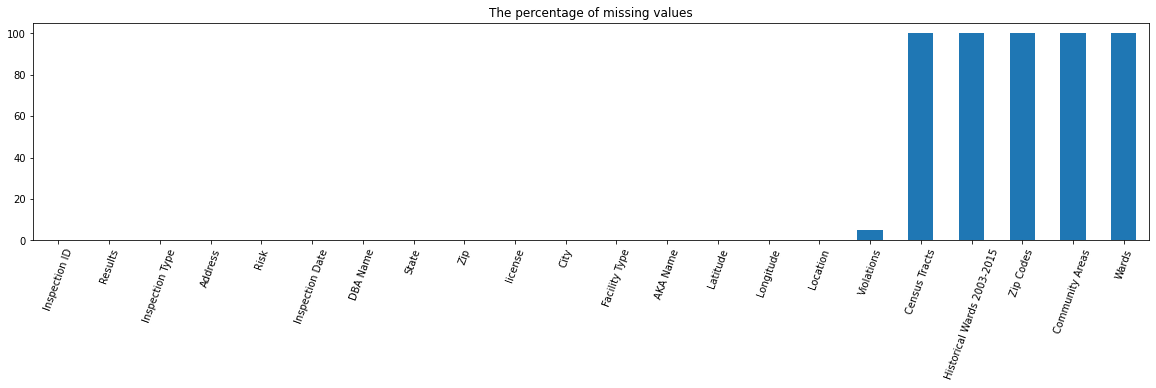

In [140]:
null_percent = df.isnull().mean()*100
null_percent.sort_values().plot.bar(figsize=(20,4), rot='70')
plt.title('The percentage of missing values')

In [141]:
print('결측치 처리 전 df shape : ', df.shape)
null_filtered = null_percent[null_percent > 60].index
df = df.drop(null_filtered, axis =1)
print('결측치 처리 후 df shape : ', df.shape)

결측치 처리 전 df shape :  (66658, 22)
결측치 처리 후 df shape :  (66658, 17)


### 4. Drop redundancy or not necessary or single unique columns

- What is DBA name?
     * In the U.S., a DBA lets the public know who the real owner of a business is. The DBA is also called a fictitious business name or assumed business name. It got its origins as a form of consumer protection, so dishonest business owners couldn't try to avoid legal trouble by operating under a different name.

In [142]:
df.drop(['AKA Name', 'City', 'State', 'Zip', 'Inspection Type', 'Location'], axis=1, inplace=True)

In [143]:
df.dropna(inplace=True)

In [144]:
pd.DataFrame({'자료형태':df.dtypes, '결측치수':df.isnull().sum(), '고유값수':df.nunique()}).sort_values('고유값수')

,자료형태,결측치수,고유값수
Results,object,0,2
Risk,object,0,3
Facility Type,object,0,264
Inspection Date,object,0,2415
Latitude,float64,0,12556
Longitude,float64,0,12556
Address,object,0,12916
DBA Name,object,0,15100
license,float64,0,17916
Violations,object,0,63000


### 5. Quick EDA

Restaurant                      43144
School                           7634
Grocery Store                    6161
Other                            3226
Bakery                           1109
Children's Services Facility      660
Long Term Care                    618
Daycare (2 - 6 Years)             612
Name: Facility Type, dtype: int64

<AxesSubplot:>

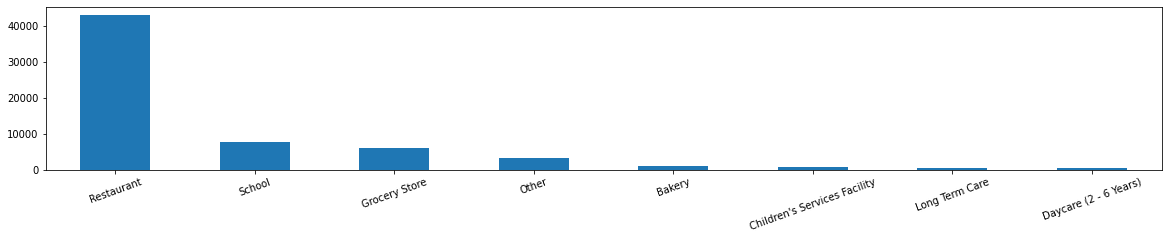

In [145]:
top_seven = df['Facility Type'].value_counts().nlargest(7).index 
df['Facility Type'] = df['Facility Type'].\
where(df['Facility Type'].isin(top_seven), other = "Other")
df['Facility Type'].value_counts()
df['Facility Type'].value_counts().plot(kind='bar', rot = '20', figsize=(20,3))

In [146]:
df['DBA Name'].replace("McDonald's", 'McDonalds', inplace=True)
df['DBA Name'].replace("Chick-fil-A", 'Chick-Fil-A', inplace=True)

<AxesSubplot:ylabel='DBA Name'>

Text(0.5, 1.0, 'Top 20 mentioned restaurants')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'SUBWAY'),
  Text(1, 0, 'DUNKIN DONUTS'),
  Text(2, 0, '7-ELEVEN'),
  Text(3, 0, 'POTBELLY SANDWICH WORKS LLC'),
  Text(4, 0, 'CORNER BAKERY CAFE'),
  Text(5, 0, 'POTBELLY SANDWICH WORKS'),
  Text(6, 0, 'CHIPOTLE MEXICAN GRILL'),
  Text(7, 0, 'SUBWAY SANDWICHES'),
  Text(8, 0, "MCDONALD'S"),
  Text(9, 0, 'AU BON PAIN'),
  Text(10, 0, 'STARBUCKS'),
  Text(11, 0, 'Subway'),
  Text(12, 0, 'THE GREAT AMERICAN BAGEL'),
  Text(13, 0, 'FRESHII'),
  Text(14, 0, 'MCDONALDS'),
  Text(15, 0, "JIMMY JOHN'S"),
  Text(16, 0, 'JIMMY JOHNS'),
  Text(17, 0, 'DUNKIN DONUTS/BASKIN ROBBINS'),
  Text(18, 0, 'PROTEIN BAR'),
  Text(19, 0, "DOMINO'S PIZZA")])

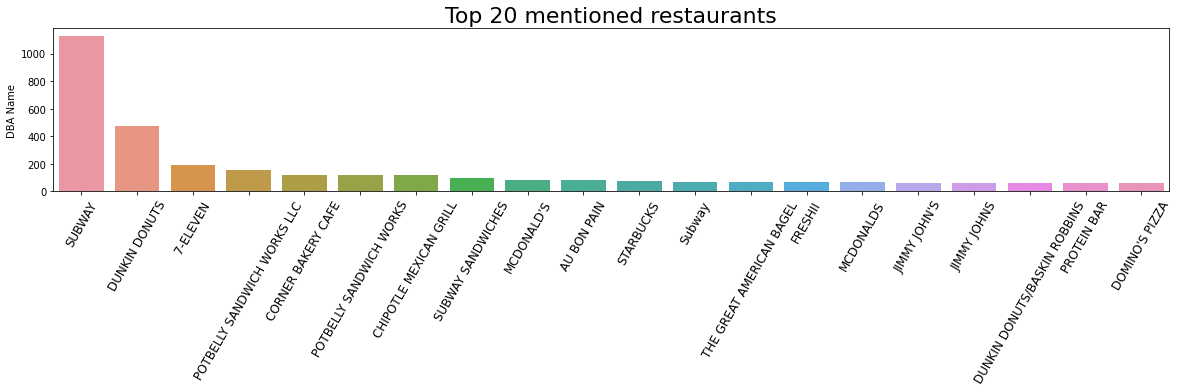

In [147]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20; fig_size[1] = 3
sns.barplot(x=df['DBA Name'].value_counts().index, y=df['DBA Name'].value_counts(),
           order = df['DBA Name'].value_counts().iloc[:20].index)
plt.title('Top 20 mentioned restaurants', fontsize=22)
plt.xticks(rotation=60, fontsize=12)

<Figure size 1080x288 with 0 Axes>

<AxesSubplot:xlabel='Facility Type', ylabel='Risk'>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Bakery'),
  Text(1.5, 0, "Children's Services Facility"),
  Text(2.5, 0, 'Daycare (2 - 6 Years)'),
  Text(3.5, 0, 'Grocery Store'),
  Text(4.5, 0, 'Long Term Care'),
  Text(5.5, 0, 'Other'),
  Text(6.5, 0, 'Restaurant'),
  Text(7.5, 0, 'School')])

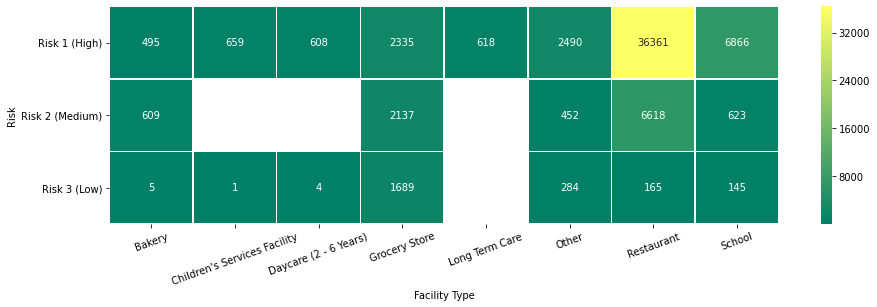

In [148]:
plt.figure(figsize=(15, 4))
data = df.groupby('Risk')['Facility Type'].value_counts().unstack()
sns.heatmap(data=data, annot=True, fmt='.0f', linewidths=.5, cmap='summer')
plt.xticks(rotation=20)

### INSPECTIONS MAP

In [149]:
# Find minimum and maximum values for latitude and longitude
la = df['Latitude'].tolist()
lo =df['Longitude'].tolist()
print('The minimum value for the latitude is: '+str(min(la)))
print('The maximum value for the latitude is: '+str(max(la)))
print('The minimum value for the longitude is: '+str(min(lo)))
print('The maximum value for the longitude is: '+str(max(lo)))

The minimum value for the latitude is: 41.64467013219805
The maximum value for the latitude is: 42.02106424782547
The minimum value for the longitude is: -87.91442843927047
The maximum value for the longitude is: -87.5250941359867


In [150]:
from folium import folium, plugins

In [151]:
m = folium.Map([41.8600, -87.6298], zoom_start=10)
# Convert to (n, 2) nd-array format for heatmap
inspections_arr = df.sample(frac=0.3)[["Latitude", "Longitude"]].values  # 20% 데이터만 무작위 추출하여 지도 시각화
m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

# 시계열분석
- pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
- Extract day, month and year from Inspection Date column

### 1. 시계열 데이터 전환

In [152]:
df['Date'] = pd.to_datetime(df['Inspection Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2019-12-04 00:00:00'))

### 2. Extract day, month and year from 'Date'  columns

In [153]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

<Figure size 1080x288 with 0 Axes>

<AxesSubplot:xlabel='month', ylabel='Risk'>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, '1'),
  Text(1.5, 0, '2'),
  Text(2.5, 0, '3'),
  Text(3.5, 0, '4'),
  Text(4.5, 0, '5'),
  Text(5.5, 0, '6'),
  Text(6.5, 0, '7'),
  Text(7.5, 0, '8'),
  Text(8.5, 0, '9'),
  Text(9.5, 0, '10'),
  Text(10.5, 0, '11'),
  Text(11.5, 0, '12')])

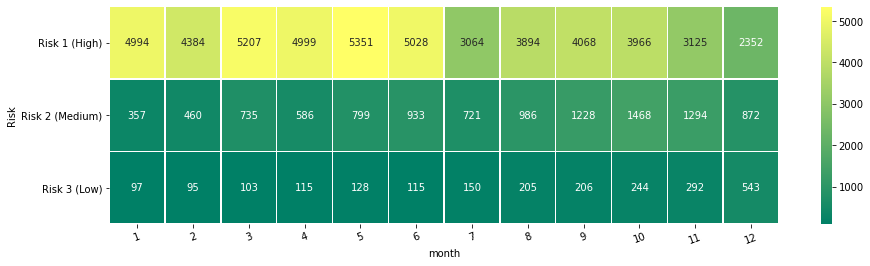

In [154]:
plt.figure(figsize=(15, 4))
data = df.groupby('Risk')['month'].value_counts().unstack()
sns.heatmap(data=data, annot=True, fmt='.0f', linewidths=.5, cmap='summer')
plt.xticks(rotation=20)

<AxesSubplot:xlabel='year'>

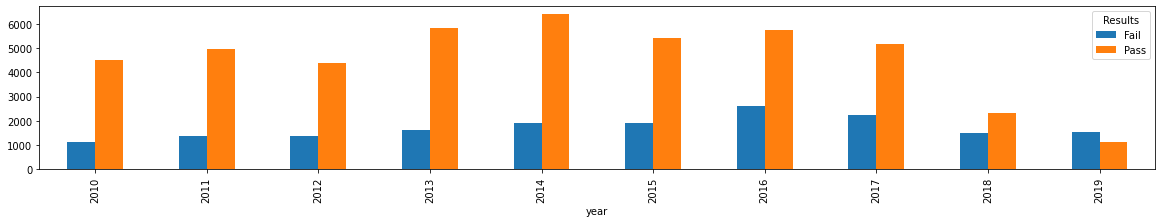

<AxesSubplot:>

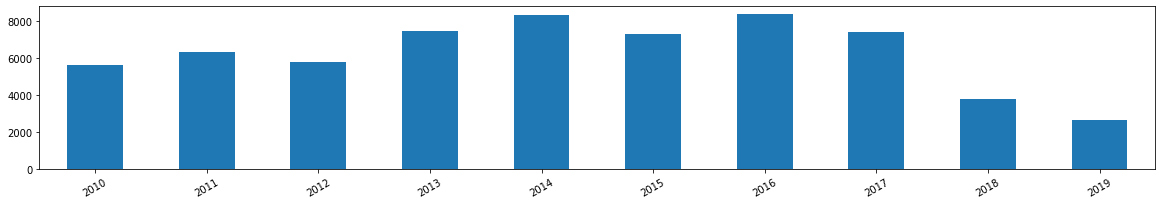

In [155]:
df.groupby('year').Results.value_counts().unstack().plot.bar(figsize=(20,3)); plt.show()
df['Date'].dt.year.value_counts().sort_index().plot(kind= 'bar',rot='30', figsize=(20,3))

<AxesSubplot:>

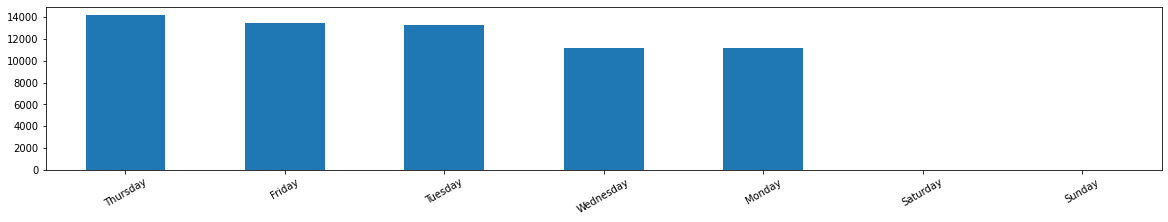

In [156]:
df['Date'].apply(lambda x: x.date().strftime('%A')).value_counts().plot(kind='bar',rot='30',figsize=(20,3))

### 3. 점검회수와 위반회수를 추출하기 위해 두개의 컬럼을 만들어 이동평균(window) 확인

In [157]:
df['점검'] = 1
df['위반'] = 0
df.loc[df['Results']== 'Fail', '위반'] = 1

<AxesSubplot:xlabel='Date'>

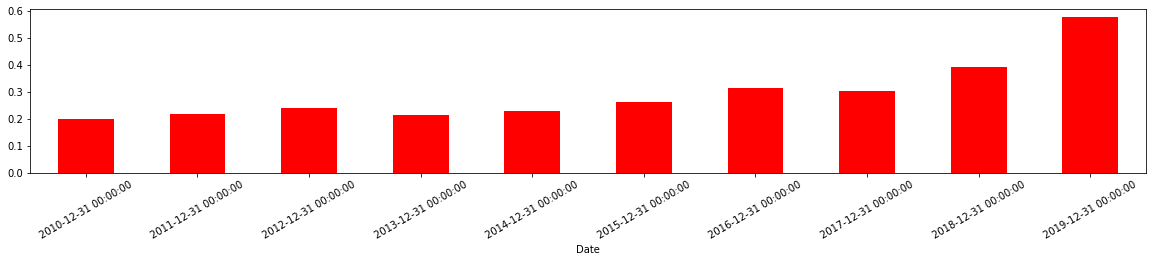

In [158]:
tf = df.set_index('Date')
tf['위반'].resample(rule='Y').mean().plot(kind='bar', rot='30', figsize=(20,3), color='red')

<AxesSubplot:xlabel='Date'>

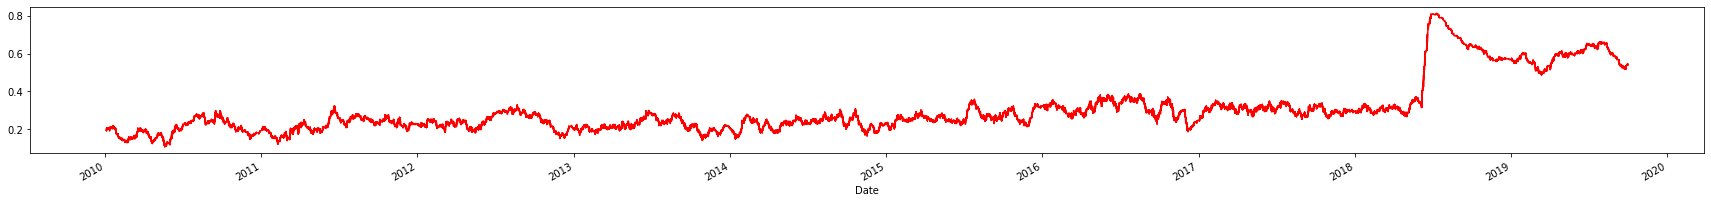

In [159]:
rolling = tf['위반'].rolling(window=365)
rolling.mean().plot(figsize=(30,3), color='red')

### 4. 최초와 최종 점검일 기간, 해당기간(영업기간) 동안 위반건수

In [160]:
print('The numbers of nan, inf & -inf : ', df.isin([np.nan, np.inf, -np.inf]).any(1).sum())

The numbers of nan, inf & -inf :  0


In [161]:
latest_data = df.sort_values('Inspection Date', ascending = False).groupby('DBA Name').head(1)
first_data = df.sort_values('Inspection Date', ascending = True).groupby('DBA Name').head(1)

len(set(latest_data['DBA Name'].unique()) & set(first_data['DBA Name'].unique()))

15099

In [162]:
data = latest_data[['DBA Name', 'Date']].merge(first_data[['DBA Name', 'Date']], on = 'DBA Name', suffixes=('_latest', '_first'))
data['영업일수'] = data['Date_latest'] - data['Date_first']
data = data.merge(df.groupby('DBA Name')['위반'].sum().reset_index(name="위반건수"), on = 'DBA Name')
data.head()

,DBA Name,Date_latest,Date_first,영업일수,위반건수
0,CHILI'S T-I,2019-12-04,2011-08-17,3031 days,2
1,JAMIESON,2019-12-04,2010-04-22,3513 days,5
2,HARRY CARAY'S SHORTSTOP,2019-12-03,2019-12-03,0 days,0
3,SUTHERLANDS,2019-12-03,2012-04-26,2777 days,2
4,AMARIT RESTAURANT,2019-12-03,2010-04-16,3518 days,6


In [163]:
df = df.merge(data[['DBA Name', '영업일수']], on = 'DBA Name')
df['영업일수'] = df['영업일수'].dt.days

### 5. High risk임에도 적합판정 결과의 절대값이 크다
- Risk에 따른 odd ratio를 3등급 구분하여 변수로 반영

In [164]:
df.groupby(['Risk', 'Results']).size().reset_index(name="Frequency") # multi index를 columns으로 변환

,Risk,Results,Frequency
0,Risk 1 (High),Fail,13889
1,Risk 1 (High),Pass,36543
2,Risk 2 (Medium),Fail,2666
3,Risk 2 (Medium),Pass,7773
4,Risk 3 (Low),Fail,697
5,Risk 3 (Low),Pass,1596


<AxesSubplot:xlabel='Results', ylabel='Risk'>

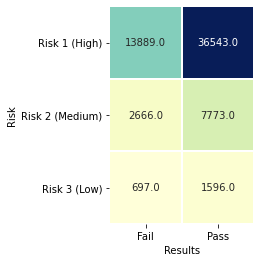

In [165]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(pd.crosstab([df.Risk], [df.Results]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

### Restaurant인지 아닌지 dummy 변수 설정
- Add new feature called Restaurant that describe if the Facility Type is restaurant or not
- high risk (more than 50%)에 대부분 데이터가 분포하고 'low risk'에는 'restaurant'비중이 아주 낮음

In [166]:
df['Restaurant'] = (df['Facility Type'].values == 'Restaurant').astype('int')

<AxesSubplot:xlabel='Risk', ylabel='Restaurant'>

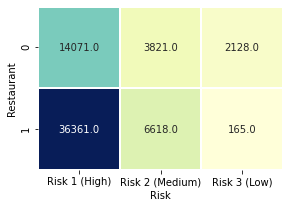

In [167]:
sns.heatmap(pd.crosstab([df.Restaurant], [df.Risk]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

# 과거 점검이력 (Inspection history)
### 1. 과거 부적합이력 확인(odds ratio)
- 최근의 부적합 판정 이력이 부적합에 가장 영향을 많이 미침
- 점검일자를 기준으로 오름차순 정리하고 
- 'license'로 그룹핑한하여 직전의 점검결과(shift())를 'previous_results' 컬럼으로 생성

In [168]:
# Sort inspections by date
df = df.sort_values(by="Inspection Date")

# Only consider inspections with clear results
df = df.loc[df.Results.isin(["Pass", "Fail"])]

# Group inspections by license and shift 1 to find previous results
df["previous_results"] = df.groupby(by="license").shift().Results

# Calculate cross tabulation of results and previous results
chart = pd.crosstab(df.previous_results, df.Results)

# Make Numpy array of total counts of prior fails and passes with the 
# following(post) results
chart_arr = np.array(chart)
chart_arr

array([[ 4254,  6475],
       [ 8137, 26382]], dtype=int64)

In [169]:
# Create new dataframe from Numpy array to clearly dispay prior and 
# post results
pass_fail_chart = pd.DataFrame({"Prior Fail":chart_arr[:,0],
                                "Prior Pass":chart_arr[:,1]})
pass_fail_chart.index = pass_fail_chart.index.rename("")
pass_fail_chart = pass_fail_chart.rename(index={0:"Post Fail",1:"Post Pass"})

# Display chart
pass_fail_chart

,Prior Fail,Prior Pass
,,
Post Fail,4254,6475
Post Pass,8137,26382


### (1) post fails 결과에서 prior fails 비율

In [170]:
pass_fail_chart.loc["Post Fail", "Prior Fail"] 
pass_fail_chart.loc["Post Fail", :].sum()
fail_fail_probability = (pass_fail_chart.loc["Post Fail", "Prior Fail"] /
                         pass_fail_chart.loc["Post Fail", :].sum())

print(str(100*fail_fail_probability) + " of prior fails resulted in a subsequent fail")

4254

10729

39.649547954142975 of prior fails resulted in a subsequent fail


### (2) post fails 결과에서 prior passes 비율

In [171]:
pass_fail_probability = (pass_fail_chart.loc["Post Pass", "Prior Fail"] /
                         pass_fail_chart.loc["Post Pass", :].sum())

print(str(100*pass_fail_probability)+ " of prior passes resulted in a subsequent fail")

23.572525275934993 of prior passes resulted in a subsequent fail


### odds ratio (2)/(1) pass/fail probability vs fail/fail probability

In [172]:
print(str(100*(1 - (pass_fail_probability / fail_fail_probability))) +" more likely that a prior fail will predict a subsequent fail than a prior pass")

40.547808254464854 more likely that a prior fail will predict a subsequent fail than a prior pass


- 최근에 부적합 판정 받은 업체의 부적합 확률은 적합판정 받은 업체보다 거의 2배가까이 높다(odd ratio)

# 지리적 정보 반영(공간정보)

In [173]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df['Latitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Latitude'] = scaler.transform(df['Latitude'][:, np.newaxis])
scaler.fit(df['Longitude'][:, np.newaxis]) # 컬럼벡터로 변환
df['Longitude'] = scaler.transform(df['Longitude'][:, np.newaxis])

df['far']=df['Latitude']*0.4 + df['Longitude'] # 위도(latitude) 경도(longitude)
df['far_q'] = pd.qcut(df['far'], q = 5, labels = np.arange(5)) 

MinMaxScaler()

MinMaxScaler()

In [174]:
df.head()

,Inspection ID,DBA Name,license,Facility Type,Risk,Address,Inspection Date,Results,Violations,Latitude,...,year,month,day,점검,위반,영업일수,Restaurant,previous_results,far,far_q
18601,104236,TEMPO CAFE,80916.0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,2010-01-04T00:00:00.000,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,0.674190,...,2010,1,4,1,1,3276,1,NaN,1.005340,4
22528,114257,SULLIVAN'S STEAKHOUSE,68917.0,Restaurant,Risk 1 (High),415 N DEARBORN ST,2010-01-05T00:00:00.000,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,0.651214,...,2010,1,5,1,0,3076,1,NaN,0.992440,4
60126,54213,SUNSET LIQUORS,13541.0,Grocery Store,Risk 3 (Low),5921 W DIVISION ST,2010-01-05T00:00:00.000,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",0.683431,...,2010,1,5,1,0,1018,0,NaN,0.634306,0
62464,124256,FERNANDO'S MEXICAN GRILL & PIZZA,1915768.0,Restaurant,Risk 1 (High),7148 N HARLEM AVE,2010-01-05T00:00:00.000,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,0.974211,...,2010,1,5,1,0,365,1,NaN,0.666156,0
35487,60244,ZARAGOZA RESTAURANT,1904141.0,Restaurant,Risk 1 (High),4852 S PULASKI RD,2010-01-05T00:00:00.000,Pass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,0.424550,...,2010,1,5,1,0,2830,1,NaN,0.659876,0


In [175]:
df['far_q'] = df['far_q'].astype('int')

In [178]:
map_dict = {'Risk 1 (High)':3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1}
df['Risk'] = df['Risk'].map(map_dict)

In [179]:
df['Results'].replace({'Pass':0, 'Fail':1}, inplace=True)

<AxesSubplot:xlabel='year', ylabel='month'>

Text(0.5, 1.0, 'Fail ratios between month & year')

<AxesSubplot:xlabel='year', ylabel='far_q'>

Text(0.5, 1.0, 'Risk ranks between year & off shore distance')

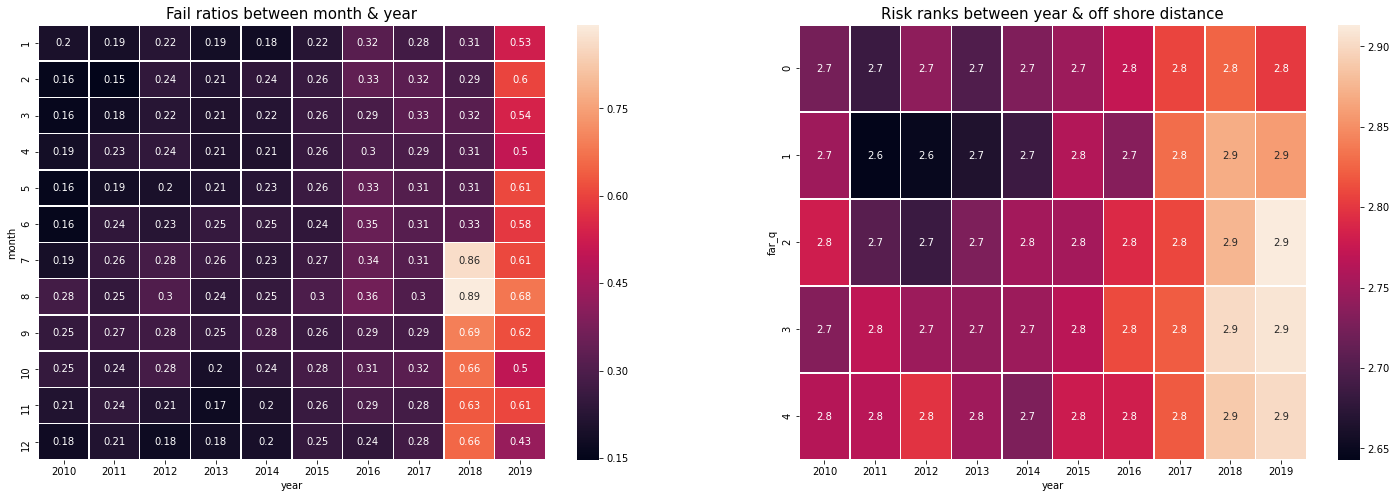

In [180]:
fig,ax=plt.subplots(1,2,figsize=(25,8)) 
tf = pd.pivot_table(df, index='month',columns='year', values='Results')
sns.heatmap(tf, annot=True, linewidths=.5,  ax=ax[0])
ax[0].set_title('Fail ratios between month & year',size=15)
af = pd.pivot_table(df, index='far_q',columns='year', values='Risk')
sns.heatmap(af, annot=True, linewidths=.5,  ax=ax[1])
ax[1].set_title('Risk ranks between year & off shore distance',size=15)

# 과거 부적합이력 파생변수 생성(시간정보)
### 1. 중복된 Inspection ID 생략

In [181]:
df.shape
df[df.duplicated('Inspection ID')].shape
df = df[~df.duplicated('Inspection ID')]
df.shape

(63164, 22)

(51, 22)

(63113, 22)

In [182]:
df = df.rename(columns={'Inspection ID': 'ID'})

In [183]:
df20 = df.groupby(['license', 'year']).agg({'점검':['sum'], '위반':['sum']})
df20.columns = ['점검', '위반']
df20 = df20.reset_index()
df20.head()

,license,year,점검,위반
0,0.0,2010,13,4
1,0.0,2011,14,1
2,0.0,2012,13,2
3,0.0,2013,11,6
4,0.0,2014,15,4


In [184]:
from itertools import product
df30 = pd.DataFrame(product(df['license'].unique(), df['year'].unique()), 
                    columns=['license','year'])
df30 .head(13)

,license,year
0,80916.0,2010
1,80916.0,2011
2,80916.0,2012
3,80916.0,2013
4,80916.0,2014
5,80916.0,2015
6,80916.0,2016
7,80916.0,2017
8,80916.0,2018
9,80916.0,2019


In [185]:
df31 = (df30.merge(df20, how='left').sort_values(['license','year']).reset_index(drop=True))

# 과거 5년간의 점검 위반 회수를 df에 생성, 점검이 없던 해(그 해 기준으로 과거 5년간의 점검 위반값을 알 수 있도록)도 데이터 생성됨
df32 = pd.DataFrame()
lags = range(1, 6)
#df31_grouped = df31.groupby(['ID'])
cols = ['점검', '위반']
for n in lags: 
    for col in cols:
        df32[f'{col} (n-{n})'] = df31.groupby(['license'])[f'{col}'].shift(n)
df_A = df31.merge(df32, left_index=True, right_index=True)
df_A.head()

,license,year,점검,위반,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
0,0.0,2010,13.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2011,14.0,1.0,13.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2012,13.0,2.0,14.0,1.0,13.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,2013,11.0,6.0,13.0,2.0,14.0,1.0,13.0,4.0,NaN,NaN,NaN,NaN
4,0.0,2014,15.0,4.0,11.0,6.0,13.0,2.0,14.0,1.0,13.0,4.0,NaN,NaN


In [186]:
df41 = df.sort_values(['license','Date']).reset_index(drop=True)
df42 = df41.groupby(['license','year']).agg({'점검':'cumsum', '위반':'cumsum'})
df43 = df41.merge(df42, left_index=True, right_index=True)
# 이번을 제외한 올해의 누적 점검횟수 위반횟수 계산
df43['점검_y'] = df43['점검_y'] - df43['점검_x']
df43['위반_y'] = df43['위반_y'] - df43['위반_x']
# df43['점검_x']은 모두 1이므로 제거
del df43['점검_x']
# 점검결과 1 --> 위반으로 설정
df_B = df43.rename(columns={'점검_y':'점검', '위반_y':'위반', '위반_x':'점검결과'})

In [187]:
df = df_B.merge(df_A, on=['license', 'year'])
del df['점검_y']; del df['위반_y']

In [188]:
# Impute checklist with 'zero'
check = ['점검 (n-1)', '위반 (n-1)', '점검 (n-2)', '위반 (n-2)', '점검 (n-3)',
         '위반 (n-3)', '점검 (n-4)', '위반 (n-4)', '점검 (n-5)', '위반 (n-5)']
for i in check :
    df[i]= df[i].fillna(0)
df[check]

,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
63108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
# object는 category 변환
for col in df.columns :
    if df[col].dtypes == 'object' :
        df[col] = df[col].astype('category')
df.rename(columns={'점검_x': '점검', '위반_x': '위반'}, inplace = True)

# Target mean encoding
- 영업소 유형과 단속 결과의 평균을 target mean

In [274]:
df.groupby(['Facility Type'])['점검결과'].mean().to_dict()
target_mean = df.groupby(['Facility Type'])['점검결과'].mean().to_dict()
df['ft_tm'] = df['Facility Type'].map(target_mean)
df.head()

{'Bakery': 0.3203971119133574,
 "Children's Services Facility": 0.20212765957446807,
 'Daycare (2 - 6 Years)': 0.20915032679738563,
 'Grocery Store': 0.3246141348497157,
 'Long Term Care': 0.35760517799352753,
 'Other': 0.2564341085271318,
 'Restaurant': 0.27043076851701503,
 'School': 0.2506554798112218}

,Facility Type,Risk,year,month,점검결과,영업일수,Restaurant,far,far_q,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5),ft_tm
ID,,,,,,,,,,,,,,,,,,,,
120273,Restaurant,2,2010,1,0,0,1,0.931746,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431
120440,Other,2,2010,4,0,968,0,0.937772,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256434
233862,Other,2,2010,5,0,1049,0,0.881492,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256434
250869,Other,0,2010,6,0,0,0,0.801081,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256434
250853,Other,2,2010,6,0,0,0,0.795969,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256434


# 필요 없는 컬럼 삭제

In [190]:
df.columns

Index(['ID', 'DBA Name', 'license', 'Facility Type', 'Risk', 'Address',
       'Inspection Date', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Date', 'year', 'month', 'day', '점검결과', '영업일수', 'Restaurant',
       'previous_results', 'far', 'far_q', '점검', '위반', '점검 (n-1)', '위반 (n-1)',
       '점검 (n-2)', '위반 (n-2)', '점검 (n-3)', '위반 (n-3)', '점검 (n-4)', '위반 (n-4)',
       '점검 (n-5)', '위반 (n-5)'],
      dtype='object')

In [191]:
df = df.drop(['license', 'DBA Name', 'Address', 'Inspection Date', 'Results',
              'Violations', 'Latitude', 'Longitude', 'Date', 'day', 
              '점검', '위반',
              'previous_results'], axis = 1)

In [193]:
df.set_index('ID', inplace=True)
df.to_pickle('../data/chicago.pkl') # 중간 저장

In [194]:
df.head()
df.shape

,Facility Type,Risk,year,month,점검결과,영업일수,Restaurant,far,far_q,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5)
ID,,,,,,,,,,,,,,,,,,,
120273,Restaurant,3,2010,1,0,0,1,0.931746,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120440,Other,3,2010,4,0,968,0,0.937772,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233862,Other,3,2010,5,0,1049,0,0.881492,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250869,Other,1,2010,6,0,0,0,0.801081,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250853,Other,3,2010,6,0,0,0,0.795969,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(63113, 19)

In [197]:
pd.DataFrame({'자료형태':df.dtypes, '결측치수':df.isnull().sum(), '고유값수':df.nunique()})

,자료형태,결측치수,고유값수
Facility Type,category,0,8
Risk,int64,0,3
year,category,0,10
month,category,0,12
점검결과,int64,0,2
영업일수,int64,0,3198
Restaurant,int32,0,2
far,float64,0,12556
far_q,int32,0,5
점검 (n-1),float64,0,17


In [198]:
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')

# 예측

In [199]:
# labelEncoder present in scikitlearn library 

from sklearn.preprocessing import LabelEncoder, StandardScaler 
le = LabelEncoder() 
df['Risk'] = le.fit_transform(df['Risk'])

In [278]:
categorical_list = df.select_dtypes(include=['category']).columns
tf = df.sample(frac=0.2)
tf.shape

(12623, 20)

In [279]:
tf.head()

,Facility Type,Risk,year,month,점검결과,영업일수,Restaurant,far,far_q,점검 (n-1),위반 (n-1),점검 (n-2),위반 (n-2),점검 (n-3),위반 (n-3),점검 (n-4),위반 (n-4),점검 (n-5),위반 (n-5),ft_tm
ID,,,,,,,,,,,,,,,,,,,,
1134317,Restaurant,2,2012,6,0,2627,1,0.988676,4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431
2169846,Restaurant,2,2018,5,1,195,1,0.944766,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431
164317,Restaurant,2,2010,2,0,3520,1,0.678164,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270431
1395236,Restaurant,2,2014,1,0,3338,1,0.922027,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.270431
1424612,Restaurant,2,2014,11,1,2259,1,0.809655,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.270431


In [275]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(tf.drop(['점검결과'], axis=1), prefix= categorical_list)
y = tf['점검결과']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,
                                          random_state = 11)

In [243]:
# Model evaluation
from sklearn.model_selection import cross_val_score, KFold
#Model evaluation metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss
from scipy.stats import ks_2samp

# 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold

# Classifiers

In [206]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [219]:
classifiers = {}
classifiers.update({'KNN': KNeighborsClassifier()})
classifiers.update({'GNB': GaussianNB()})
classifiers.update({'LGR': LogisticRegression(class_weight='balanced', random_state=11, solver ='liblinear')})
classifiers.update({'SVC': SVC(class_weight='balanced', probability=True, max_iter=300)})
classifiers.update({'Decisiontree': DecisionTreeClassifier()})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', 
                                                 n_estimators=300)})
classifiers.update({'Gradient Boosting': GradientBoostingClassifier()})

- RidgeClassifier()는 종속변수 y를 ‘1’과 ‘-1’로 변경하고 선형 최소제곱을 손실함수로 하여 로지스틱 회귀에 penalty 2(L2)를 적용한 모델이다. 
      * RidgeClassifier()는 다항 분류 예측일 경우에 로지스틱회귀보다 연산 속도가 빠르다. 

- Extra-Trees()는 랜덤포레스트 알고리즘과는 다르게 각 노드의 불순도를 줄이는 대신에 무작위 분류기준(random thresholds)을 설정한다. 
      * Extra-Trees() 분류기는 무작위성 트리(Extremely Randomized Trees)를 구성하여 분산을 줄이는 대가로 편향을 높게 하여 예측한다.

In [220]:
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import ExtraTreeClassifier

classifiers.update({'Ridge': RidgeClassifier()})
classifiers.update({'Extra Trees': ExtraTreeClassifier()})

classifiers

{'KNN': KNeighborsClassifier(),
 'GNB': GaussianNB(),
 'LGR': LogisticRegression(class_weight='balanced', random_state=11, solver='liblinear'),
 'SVC': SVC(class_weight='balanced', max_iter=300, probability=True),
 'Decisiontree': DecisionTreeClassifier(),
 'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=300),
 'Gradient Boosting': GradientBoostingClassifier(),
 'Ridge': RidgeClassifier(),
 'Extra Trees': ExtraTreeClassifier()}

- 예측 확률을 구하는 함수가 다른 ‘SVC’와 ‘Ridge’를 저장한다

In [208]:
DECISION_FUNCTIONS = {'SVC', 'Ridge'}

# Parameters

In [222]:
parameters = {}
parameters.update({'KNN': 
{ 
'classifier__n_neighbors': [1, 2, 3, 11, 17], 'classifier__weights': ['uniform','distance'],
'classifier__leaf_size': list(range(4,6))}
})

In [223]:
parameters.update({'GNB': {}})

In [224]:
parameters.update({'LGR': 
{ 
'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l1', 'l2']}
})

In [225]:
parameters.update({'SVC': 
{ 
'classifier__kernel': ['linear', 'rbf', 'poly'],
'classifier__gamma': ['auto'],
'classifier__C': [0.1, 0.5, 1, 5, 10, 50, 100],
'classifier__degree': [1, 2, 3, 4, 5, 6]
}})

In [226]:
parameters.update({'Decisiontree': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [227]:
parameters.update({'Random Forest': 
{ 
'classifier__n_estimators': [200],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__criterion' :['gini', 'entropy']     ,
'classifier__n_jobs': [-1]
}})

In [228]:
parameters.update({'Gradient Boosting': 
{ 
'classifier__learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
'classifier__n_estimators': [200],
'classifier__max_depth': [2,3,4,5,6],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__subsample': [0.8, 0.9, 1]
}})

In [229]:
parameters.update({'Ridge': 
{ 
'classifier__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
}})

In [230]:
parameters.update({'Extra Trees': 
{ 
'classifier__criterion' :['gini', 'entropy'],
'classifier__splitter': ['best', 'random'],
'classifier__class_weight': [None, 'balanced'],
'classifier__max_features': ['auto', 'sqrt', 'log2'],
'classifier__max_depth' : [1,2,3, 4, 5, 6, 7, 8],
'classifier__min_samples_split': [0.005, 0.01, 0.05, 0.10],
'classifier__min_samples_leaf': [0.005, 0.01, 0.05, 0.10],
}})

In [248]:
from tqdm import tqdm_notebook
from joblib import dump, load
kf = KFold(n_splits=3)

In [249]:
results = {}
for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('scaler', StandardScaler()), ('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,  n_iter = 10,
                            scoring = 'recall_macro')    


    y_pred = gs.fit(X_train, y_train).predict(X_test)
    
    if classifier_label in DECISION_FUNCTIONS:
        y_proba = gs.decision_function(X_test)
        ap = average_precision_score(y_test, y_proba)
    else:
        y_proba = gs.predict_proba(X_test)[:,1]
        ap = average_precision_score(y_test, y_proba)

   
    result = {'Best Parameters': gs.best_params_,
              'Training recall_macro': gs.best_score_,
              'AUROC': roc_auc_score(y_test, y_proba),
              'Average PR': ap,
              'F1-score': f1_score(y_test, y_pred),
              'CV accuracy': cross_val_score(gs, X_train, y_train).mean(),
              'Log_loss': log_loss(y_test, y_proba),
             }
    
    results.update({classifier_label: result})

dump(gs.fit(X_train, y_train), '../output/chicago_%s.joblib'%classifier_label)

['../output/chicago_Extra Trees.joblib']

In [250]:
pd.DataFrame(results).T.sort_values(by = 'F1-score', ascending=False)

,Best Parameters,Training recall_macro,AUROC,Average PR,F1-score,CV accuracy,Log_loss
LGR,"{'classifier__penalty': 'l2', 'classifier__C':...",0.597885,0.61078,0.395188,0.429141,0.59813,0.674967
Random Forest,"{'classifier__n_jobs': -1, 'classifier__n_esti...",0.595767,0.612213,0.400315,0.428896,0.590789,0.671012
Decisiontree,"{'classifier__splitter': 'random', 'classifier...",0.549609,0.544186,0.307223,0.421672,0.562762,0.690352
SVC,"{'classifier__kernel': 'linear', 'classifier__...",0.520106,0.484679,0.273632,0.352133,0.502671,13.22127
GNB,{},0.561867,0.598622,0.357447,0.337449,0.559004,1.903673
Extra Trees,"{'classifier__splitter': 'best', 'classifier__...",0.554772,0.561287,0.307886,0.334118,0.533361,0.688067
KNN,"{'classifier__weights': 'uniform', 'classifier...",0.547301,0.562106,0.322335,0.32577,0.542324,4.357862
Gradient Boosting,"{'classifier__subsample': 0.8, 'classifier__n_...",0.54173,0.610481,0.405272,0.189349,0.54601,0.574587
Ridge,{'classifier__alpha': 1e-07},0.537103,0.611992,0.395955,0.135301,0.536923,8.932206


In [258]:
import glob
glob.glob('../output/*.joblib')

['../output\\chicago_Extra Trees.joblib',
 '../output\\dt.joblib',
 '../output\\gnb.joblib',
 '../output\\Gradient Boosting.joblib',
 '../output\\knn.joblib',
 '../output\\lgr.joblib',
 '../output\\Random Forest.joblib']

# 보정 곡선(Calibration plot)
- 보정 곡선은 모델의 예측값을 기준으로 10분위 구간 (0%, 10%, 20%, … 90, 100%)의 구간으로 예측 확률과 실제 비율의 관계를 나타낸다
- 빈 리스트 형태의 변수를 생성한 후 반복문을 통해 모든 모델의 key와 values를 하나씩 읽어와 예측 확률과 모델명을 기록한다. 

In [254]:
classifier_labels = []
probas_list = []
for classifier_label, classifier in classifiers.items():
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}   
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2, scoring = 'f1_micro')  
    
    if classifier_label in DECISION_FUNCTIONS:
        y_proba = gs.fit(X_train, y_train).decision_function(X_test)
    else:
        y_proba = gs.fit(X_train, y_train).predict_proba(X_test)
       
    probas_list.append(y_proba)
    classifier_labels.append(classifier_label)

- 모델명과 예측 확률로 skplt.metrics.plot() 함수를 사용하여 보정 곡선을 확인한다. 
- 45 도선을(Perfectly calibrated) 따라가면 예측 확률이 균등하게 분포된 형태로 신뢰구간과 같은 역할을 한다

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

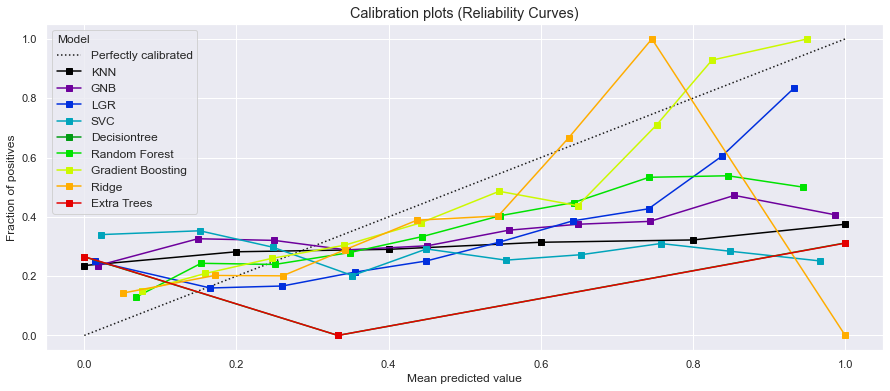

In [257]:
import scikitplot as skplt
sns.set()
skplt.metrics.plot_calibration_curve(y_test, probas_list, classifier_labels, figsize=(15,6))
leg = plt.legend(title='Model', fontsize = 12)
leg._legend_box.align = 'left'

# pycaret

In [ ]:
from pycaret.classification import *
clf  = setup(data = tf, 
             target = '점검결과',
             normalize = True,
             train_size = 0.8)

In [99]:
ensemble = models(type ='ensemble').index.tolist()
ensemble

['rf', 'ada', 'gbc', 'et', 'xgboost', 'lightgbm', 'catboost']

In [100]:
compare_models(fold = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7405,0.6498,0.1329,0.6113,0.2181,0.1340,0.1908,0.2200
catboost,CatBoost Classifier,0.7388,0.6470,0.1456,0.5848,0.2331,0.1395,0.1891,4.7733
lr,Logistic Regression,0.7381,0.6471,0.1115,0.6076,0.1882,0.1134,0.1724,1.1333
gbc,Gradient Boosting Classifier,0.7381,0.6515,0.1097,0.6097,0.1858,0.1121,0.1718,0.4900
ridge,Ridge Classifier,0.7373,0.0000,0.1020,0.6094,0.1745,0.1047,0.1651,0.0667
lda,Linear Discriminant Analysis,0.7372,0.6456,0.1227,0.5867,0.2028,0.1199,0.1733,0.0767
lightgbm,Light Gradient Boosting Machine,0.7324,0.6321,0.1525,0.5342,0.2371,0.1318,0.1703,0.1533
rf,Random Forest Classifier,0.7271,0.6320,0.1583,0.4993,0.2404,0.1255,0.1564,0.2833
svm,SVM - Linear Kernel,0.7260,0.0000,0.0959,0.5066,0.1517,0.0758,0.1119,0.0800
xgboost,Extreme Gradient Boosting,0.7156,0.6246,0.2062,0.4531,0.2834,0.1360,0.1524,1.0233


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1841)

In [103]:
ada = create_model('ada', fold = 3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7362,0.6602,0.1155,0.5824,0.1927,0.1126,0.1663
1,0.7436,0.6474,0.1373,0.6396,0.2260,0.1435,0.2054
2,0.7418,0.6419,0.1460,0.6119,0.2357,0.1460,0.2009
Mean,0.7405,0.6498,0.1329,0.6113,0.2181,0.1340,0.1908
SD,0.0032,0.0076,0.0128,0.0233,0.0184,0.0152,0.0175


In [104]:
tunes_ada = tune_model(ada, fold = 3)
tunes_ada

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7362,0.6658,0.0817,0.6250,0.1445,0.0869,0.1521
1,0.7409,0.6466,0.1002,0.6667,0.1742,0.1109,0.1829
2,0.7406,0.6428,0.1111,0.6415,0.1894,0.1184,0.1844
Mean,0.7393,0.6517,0.0977,0.6444,0.1694,0.1054,0.1731
SD,0.0022,0.0101,0.0121,0.0171,0.0187,0.0134,0.0149


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.376, n_estimators=90, random_state=1841)

In [105]:
evaluate_model(tunes_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [280]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                         learning_rate=0.376, n_estimators=90, random_state=1841)
y_predict = ada_clf.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.7239603960396039

In [281]:
print(classification_report(y_test, y_predict))
y_proba = ada_clf.predict_proba(X_test)
roc_auc_score(y_test, y_proba[:, 1])
average_precision_score(y_test, y_proba[:, 1])

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      1821
           1       0.54      0.07      0.13       704

    accuracy                           0.72      2525
   macro avg       0.63      0.52      0.48      2525
weighted avg       0.68      0.72      0.64      2525



0.6112190167740004

0.4019704162152196

# End